In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
stock_news_data = pd.read_csv("AAPL_data.csv")
nan_counts = stock_news_data.isna().sum()
print(nan_counts)
# stock_news_data['5-Moving Average'] = stock_news_data['Adj Close'].rolling(window=5).mean()
# stock_news_data['20-Moving Average'] = stock_news_data['Adj Close'].rolling(window=20).mean()
# stock_news_data['Sentiment 5-Moving Average'] = stock_news_data['headline_score'].rolling(window=5).mean()
# stock_news_data['Sentiment 20-Moving Average'] = stock_news_data['headline_score'].rolling(window=20).mean()
stock_news_data = stock_news_data.dropna()

Date                0
Open                0
High                0
Low                 0
Adj Close           0
Volume              0
Prev Day            1
Target              0
Adj Close Change    1
headline_score      0
dtype: int64


In [3]:
# Assume df is your DataFrame
scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'headline_score']
close = stock_news_data[['Adj Close']].copy()
stock_news_data[features] = scaler.fit_transform(stock_news_data[features])
adj_close = scaler.fit_transform(close)

# Function to create windows of time-series data
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i+window_size])
    return np.array(windows)

window_size = 3
X = create_windows(stock_news_data[features].values, window_size)
y = adj_close[window_size:]
print(X.shape)
print(y.shape)


(246, 3, 6)
(246, 1)


In [4]:
split_ratio = 0.7
split_point = int(len(X) * split_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [6]:
model = Sequential()
# Convolutional layer that will process each window
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(window_size, len(features))))
#model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
#batch size
#batch_size= int(len(X_train)/3)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=500,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)  # Restores model weights from the epoch with the best value of the monitored quantity.

# Train with early stopping and a validation split
history = model.fit(X_train, y_train, epochs=1500, batch_size=32, validation_data=(X_test, y_test), shuffle=False, callbacks=[early_stopping])

#model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
predictions = model.predict(X_test)

Epoch 1/1500
6/6 [==============================] - 3s 131ms/step - loss: 0.1757 - val_loss: 0.6590
Epoch 2/1500
6/6 [==============================] - 0s 7ms/step - loss: 0.1534 - val_loss: 0.5926
Epoch 3/1500
6/6 [==============================] - 0s 7ms/step - loss: 0.1268 - val_loss: 0.4994
Epoch 4/1500
6/6 [==============================] - 0s 7ms/step - loss: 0.0928 - val_loss: 0.3622
Epoch 5/1500
6/6 [==============================] - 0s 6ms/step - loss: 0.0515 - val_loss: 0.1762
Epoch 6/1500
6/6 [==============================] - 0s 7ms/step - loss: 0.0204 - val_loss: 0.0250
Epoch 7/1500
6/6 [==============================] - 0s 6ms/step - loss: 0.0320 - val_loss: 0.0040
Epoch 8/1500
6/6 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0266
Epoch 9/1500
6/6 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0461
Epoch 10/1500
6/6 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0247
Epoch 11/1500
6/6

In [8]:
predictions = predictions.reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)
print(predictions.shape)

(74, 1)


In [9]:
def custom_sign(x):
    return np.where(x < 0, 0, 1)

def direction_accuracy(close, predictions, target):
    target_reset = target.reset_index(drop=True)
    predict_direction_reset = custom_sign(predictions - np.array(close))
    #predict_direction_reset = predict_direction.reset_index(drop=True)
    accuracy = np.mean(target_reset[1:] == predict_direction_reset[:-1])
    return accuracy

# Calculate directional accuracy
Target = stock_news_data['Target'][window_size:][split_point:]
close1 = close[window_size-1:-1][split_point:].values.flatten()
acc = direction_accuracy(close1, predictions.flatten(), Target)
print(f'Directional Accuracy: {acc:.2%}')

Directional Accuracy: 46.58%


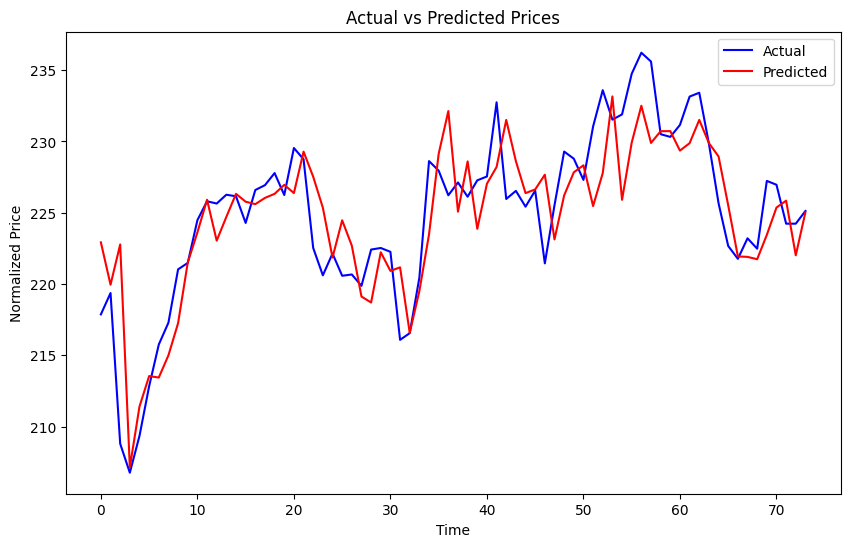

In [10]:
actual = scaler.inverse_transform(y_test)
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()